In [1]:
import copy
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
s = 1.2
r = 0.035
rho = 0.05
z1 = .1
z2 = .2
z = np.array([z1,z2])
la1 = 1.5
la2 = 1
la = np.array([la1,la2])
I=500
amin=-0.02
amax=3
a=np.linspace(amin, amax, I)
da=(amax-amin)/(I-1)
aa=np.array([a,a]).T
zz=np.ones((I,1))*z

maxit= 100
Delta = 1000
crit = 10**(-6)

dVf = np.zeros((I,2))
dVb = np.zeros((I,2))
c=np.zeros((I,2))


"""Ini0tial guess"""
v01 = (z[0]+r*a)**(1-s)/(1-s)/rho
v02 = (z[1]+r*a)**(1-s)/(1-s)/rho
v0=np.array([v01,v02]).T
v=copy.deepcopy(v0)


Aswitch1 = scipy.sparse.hstack([-scipy.sparse.eye(I)*la1, scipy.sparse.eye(I)*la1])
Aswitch2 = scipy.sparse.hstack([scipy.sparse.eye(I)*la2, -scipy.sparse.eye(I)*la2])
Aswitch = scipy.sparse.vstack([Aswitch1, Aswitch2])

dist=np.zeros(maxit)

In [2]:
for n in range(maxit):
    V = copy.deepcopy(v)
    ## forward difference method eq.(8)
    dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVf[I-1,:] = 1 ## never be used, but set 1 make sure there is no exception
    ## backward difference method eq.(8)
    dVb[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVb[0,:] = (z+r*amin)**(-s)
    ## consumption and savings with forward difference     u=x^(1-s)/1-s  => (u')^-1: x^(-1/s) 
    cf = dVf**(-1/s)
    sf = zz + r*aa - cf
    ## consumption and savings with backward difference
    cb = dVb**(-1/s)
    sb = zz + r*aa - cb
    ## consumption and derivative of value function at steady state
    c0 = zz + r*aa
    dV0 = c0**(-s)
    ## the indicator of upwind scheme 
    If = np.where(sf>0, 1, 0)
    Ib = np.where(sb<0, 1, 0)
    I0 = (1-If-Ib)     ## sijF<0<sijB
    dV_Upwind = dVf*If + dVb*Ib + dV0*I0
    ## compute c and u
    c = dV_Upwind**(-1/s)
    u = c**(1-s)/(1-s)
    ## CONSTRUCT MATRIX
    X = -np.minimum(sb,0)/da
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da
    A1 = scipy.sparse.spdiags(Y[:,0],0,I,I)+scipy.sparse.spdiags(X[1:,0],-1,I,I)+scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:,0]]),1,I,I)
    A2 = scipy.sparse.spdiags(Y[:,1],0,I,I)+scipy.sparse.spdiags(X[1:,1],-1,I,I)+scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:,1]]),1,I,I)
    A = scipy.sparse.vstack([scipy.sparse.hstack([A1, scipy.sparse.csc_matrix((I,I))]), scipy.sparse.hstack([scipy.sparse.csc_matrix((I,I)), A2])]) + Aswitch
    B = (rho + 1/Delta)*scipy.sparse.eye(2*I) - A
    u_stacked = np.vstack((u[:,0].reshape((I,1)), u[:,1].reshape((I,1))))
    V_stacked = np.vstack([V[:,0].reshape((I,1)), V[:,1].reshape((I,1))])
    b = u_stacked + V_stacked/Delta
    V_stacked = scipy.sparse.linalg.spsolve(B, b)
    V[:,0] = np.squeeze(V_stacked[0:I])
    V[:,1] = np.squeeze(V_stacked[I:])
    Vchange = V - v
    v=copy.deepcopy(V)
    dist[n] = np.max(np.abs(Vchange))
    if dist[n] < crit:
        print("Value function is converged. Iteration is:", n)
        break

Value function is converged. Iteration is: 7


In [19]:
AT = A.T 
b = np.zeros((2*I,1))

""" 
consider page 9. We need to fix g[i,j]=0.1 (for an arbitrary (i,j)).
Fixing it can be solved by setting one element from the 0 of eq(20) ATg=0 to be 0.1
For convenience, we set g[0,j] = 0.1 
"""
i_fix = 0
b[i_fix] = 0.1
row = np.zeros(I*2)
row[i_fix] = 1
AT[i_fix,:] = row

""" 
solve eq(20) ATg=0
"""
gg = scipy.sparse.linalg.spsolve(AT, b)
gg_sum = gg.T @ np.ones((2*I,1)) * da
gg = gg/gg_sum
g1 = gg[0:I]
g2 = gg[I:]

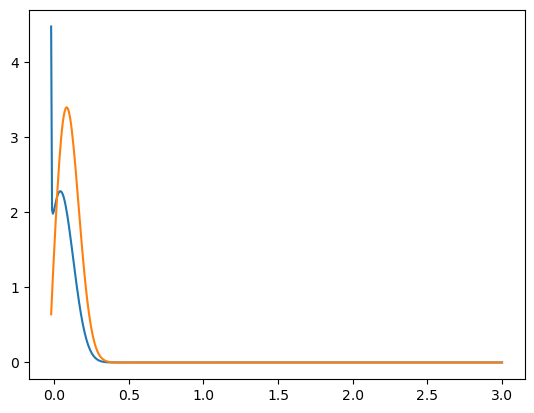

In [43]:
import matplotlib.pyplot as plt
plt.plot(a, g1)
plt.plot(a, g2)

In [2]:
V = copy.deepcopy(v)
    ## forward difference method eq.(8)
dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
dVf[I-1,:] = 1 ## never be used, but set 1 make sure there is no exception

In [4]:
v0

array([[-158.71214102, -138.06975056],
       [-158.6445156 , -138.04042011],
       [-158.57706269, -138.01112699],
       [-158.5097815 , -137.98187114],
       [-158.44267123, -137.95265245],
       [-158.37573107, -137.92347085],
       [-158.30896024, -137.89432625],
       [-158.24235796, -137.86521856],
       [-158.17592346, -137.83614769],
       [-158.10965594, -137.80711357],
       [-158.04355466, -137.7781161 ],
       [-157.97761883, -137.74915521],
       [-157.91184772, -137.7202308 ],
       [-157.84624056, -137.69134279],
       [-157.78079661, -137.66249111],
       [-157.71551512, -137.63367566],
       [-157.65039535, -137.60489636],
       [-157.58543658, -137.57615313],
       [-157.52063808, -137.54744589],
       [-157.45599912, -137.51877455],
       [-157.39151897, -137.49013903],
       [-157.32719694, -137.46153925],
       [-157.26303231, -137.43297513],
       [-157.19902437, -137.40444658],
       [-157.13517243, -137.37595353],
       [-157.07147578, -1